In [40]:
!pip install datasets
# !pip install ipywidgets
!pip install tqdm
# !pip install tensorflow

In [41]:
from datasets import load_dataset

dataset_raw = load_dataset("sebastiandizon/genius-song-lyrics")
#dataset = load_dataset("sebastiandizon/genius-song-lyrics", split="train[:100000]")

Loading dataset shards:   0%|          | 0/19 [00:00<?, ?it/s]

In [42]:
dataset = dataset_raw["train"].shuffle(seed=42).select(range(10000))

In [43]:
dataset

Dataset({
    features: ['title', 'tag', 'artist', 'year', 'views', 'features', 'lyrics', 'id', 'language_cld3', 'language_ft', 'language'],
    num_rows: 10000
})

In [44]:
# drop id
dataset = dataset.remove_columns(['id'])
#drop views
dataset = dataset.remove_columns(['views'])

In [45]:
import multiprocessing
num_cpus = multiprocessing.cpu_count()
num_cpus

2

In [46]:
# drop non-english songs
dataset = dataset.filter(
    lambda song: song['language'] == 'en' and song['language_ft'] == 'en' and song['language_cld3'] == 'en',
    num_proc = num_cpus
)
dataset = dataset.remove_columns(['language_cld3', 'language_ft', 'language', 'artist', 'year', 'features'])

In [47]:
# see how many observations/rows in dataset along with our features
dataset

Dataset({
    features: ['title', 'tag', 'lyrics'],
    num_rows: 6613
})

In [48]:
import re

def generate_tokens(batch):
    tokenized_lyrics = []
    for lyrics in batch["lyrics"]:
        tokens = re.findall(r"[\w']+|[.,!?;(){}\[\]]", lyrics) # tokenize by word and punctuation
        section = "N/A"
        sectioned_tokens = []  # stores (word, section) pairs

        for token_idx, token in enumerate(tokens):
            if token == "[":
                section = tokens[token_idx + 1]
            sectioned_tokens.append((token.lower(), section))
        tokenized_lyrics.append(sectioned_tokens)

    return {"lyric_tokens": tokenized_lyrics}

dataset = dataset.map(generate_tokens, batched=True, num_proc=num_cpus)

In [49]:
dataset

Dataset({
    features: ['title', 'tag', 'lyrics', 'lyric_tokens'],
    num_rows: 6613
})

In [50]:
dataset["lyric_tokens"][0]

[['[', 'Intro'],
 ['intro', 'Intro'],
 [']', 'Intro'],
 ['bitch', 'Intro'],
 ["i'm", 'Intro'],
 ['clean', 'Intro'],
 ['two', 'Intro'],
 ['sticks', 'Intro'],
 ['like', 'Intro'],
 ['chow', 'Intro'],
 ['mein', 'Intro'],
 ['two', 'Intro'],
 ['sticks', 'Intro'],
 ['like', 'Intro'],
 ['chow', 'Intro'],
 ['mein', 'Intro'],
 ['bitch', 'Intro'],
 ["i'm", 'Intro'],
 ['clean', 'Intro'],
 ['two', 'Intro'],
 ['sticks', 'Intro'],
 ['like', 'Intro'],
 ['chow', 'Intro'],
 ['mein', 'Intro'],
 ['two', 'Intro'],
 ['sticks', 'Intro'],
 ['like', 'Intro'],
 ['chow', 'Intro'],
 ['mein', 'Intro'],
 ['two', 'Intro'],
 ['sticks', 'Intro'],
 ['like', 'Intro'],
 ['chow', 'Intro'],
 ['mein', 'Intro'],
 ['[', 'Hook'],
 ['hook', 'Hook'],
 [']', 'Hook'],
 ['bitch', 'Hook'],
 ["i'm", 'Hook'],
 ['clean', 'Hook'],
 ['two', 'Hook'],
 ['sticks', 'Hook'],
 ['like', 'Hook'],
 ['chow', 'Hook'],
 ['mein', 'Hook'],
 ['two', 'Hook'],
 ['sticks', 'Hook'],
 ['like', 'Hook'],
 ['chow', 'Hook'],
 ['mein', 'Hook'],
 ['two', 'Hook'],

In [51]:
# check our tags/genres
set(dataset['tag'])

{'country', 'misc', 'pop', 'rap', 'rb', 'rock'}

In [52]:
import numpy as np
from collections import defaultdict, Counter, deque
from tqdm import tqdm
import itertools

class NGramHMM:
    START_TOKEN = "<START>"
    STOP_TOKEN = "<STOP>" # don't worry about stop tokens for now
    UNK_TOKEN = "<UNK>"

    def __init__(self, states, tag, word_n, section_n, vocab_size=10000, smoothing=1):
        self.tag = tag
        self.word_n = word_n
        self.section_n = section_n

        self.vocab_size = vocab_size
        self.vocab = []
        self.smoothing = smoothing  # laplace smoothing
        self.word_ngram_counts = defaultdict(lambda: defaultdict(lambda: defaultdict(int))) # word_ngram_counts[section][prev word_n - 1 words as list][word]
        self.section_ngram_counts = defaultdict(lambda: defaultdict(int)) # section_ngram_counts[prev section_n - 1 sections][section]

        self.states = states # song sections (ex. Chorus, Intro, Hook)
        self.S = len(states)
        self.T = vocab_size  # num words in vocab (set later)
        self.initial_probs = defaultdict(int)

    def fit(self, dataset):
        vocab_counter = Counter()
        songs_in_tag = []
        for _, song in tqdm(enumerate(dataset), total=len(dataset)):
            if song["tag"] != self.tag:
                continue

            songs_in_tag.append(song["lyric_tokens"])
            first_section = ""
            for token, section in song["lyric_tokens"]:
                if first_section == "":
                    self.initial_probs[section] += 1
                    first_section = section
                vocab_counter[token] += 1

        # handle initial probs
        for section in self.states:
            self.initial_probs[section] = (self.initial_probs[section] + self.smoothing) / (len(songs_in_tag) + self.smoothing * len(songs_in_tag))

        # get vocab - all words with count < vocab_size are converted to UNK_TOKEN
        self.vocab.append(self.UNK_TOKEN)
        for word, count in vocab_counter.most_common(self.vocab_size):
            self.vocab.append(word)

        # add START_TOKEN and STOP_TOKEN to vocab
        self.vocab.append(self.START_TOKEN)
        self.vocab.append(self.STOP_TOKEN)

        # populate our ngram counts
        word_ngram = deque([self.START_TOKEN] * (self.word_n - 1))
        section_ngram = deque([self.START_TOKEN] * (self.section_n - 1))
        for _, song in tqdm(enumerate(songs_in_tag), total=len(songs_in_tag)):
            #print(_)
            #print(song)
            for token, section in song:
                self.word_ngram_counts[section][str(list(word_ngram))][token] += 1
                self.section_ngram_counts[str(list(section_ngram))][section] += 1
                word_ngram.append(token if token in self.vocab else self.UNK_TOKEN)
                section_ngram.append(section)
                word_ngram.popleft()
                section_ngram.popleft()

    # use for transitions
    def get_section_probs(self, section_ngram, section):
        prior = str(list(section_ngram))
        prior_count = sum(self.section_ngram_counts[prior].values())
        return (self.section_ngram_counts[prior][section] + self.smoothing) / (prior_count + self.smoothing * self.S) # apply laplace smoothing

    # use for emissions
    def get_word_probs(self, word_ngram, word, section):
        prior = str(list(word_ngram))
        prior_count = sum(sum(self.word_ngram_counts[sec][prior].values()) for sec in self.states) # marginalize over section since our prior should just be the prev n - 1 words
        return (self.word_ngram_counts[section][prior][word] + self.smoothing) / (prior_count + self.smoothing * self.T)

    def get_log_likelihood(self, lyrics):
        L = len(lyrics)
        alpha = np.zeros((L, self.S))
        word_ngram = deque([self.START_TOKEN] * (self.word_n - 1))

        # get initial alpha
        for section_idx in range(self.S):
            alpha[0, section_idx] = np.log(self.initial_probs[self.states[section_idx]]) + np.log(self.get_word_probs(word_ngram, lyrics[0], self.states[section_idx]))
            word_ngram.append(lyrics[0])
            word_ngram.popleft()

        # use forward algorithm to calculate the log likelihood of the given lyrics
        for lyrics_idx in tqdm(range(1, L)):
            cur_word = lyrics[lyrics_idx]
            for cur_state_idx, cur_state in enumerate(self.states):
                log_obs = np.log(self.get_word_probs(word_ngram, cur_word, cur_state))
                tot = -np.inf
                for prev_states in itertools.product(range(self.S), repeat=self.section_n-1):
                    prev_sections = [self.states[state] for state in prev_states]
                    log_transition = self.get_section_probs(prev_sections, cur_state)
                    tot = np.logaddexp(tot, log_transition + alpha[lyrics_idx - 1, prev_states[-1]])
                alpha[lyrics_idx, cur_state_idx] = tot + log_obs
            word_ngram.append(cur_word)
            word_ngram.popleft()
        #print(alpha)

        ll = np.sum(alpha[L - 1])
        return ll

    def generate(self, starter, start_section="Intro", length=50):
        generated_lyrics = starter
        section_sequence = [start_section] * len(starter)

        word_ngram = deque([self.START_TOKEN] * (self.word_n - 1))
        for i in range(len(starter)):
            word_ngram.append(starter[i] if starter[i] in self.vocab else self.UNK_TOKEN)
            word_ngram.popleft()
        #print(word_ngram)

        for _ in tqdm(range(length)):
            # greedily choose next word with highest probability ngram
            next_word = ""
            next_word_prob = 0.0
            next_section = section_sequence[-1]
            for word in self.vocab:
                if word == self.START_TOKEN or word == self.UNK_TOKEN or word == self.STOP_TOKEN:
                    continue
                for section in self.states:
                  prob = self.get_word_probs(word_ngram, word, section)
                  if next_word_prob < prob:
                      next_word_prob = prob
                      next_word = word
                      next_section = section

            generated_lyrics.append(next_word)
            section_sequence.append(next_section)

            #print(word_ngram)
            word_ngram.append(next_word)
            word_ngram.popleft()

        return " ".join(generated_lyrics), section_sequence


In [53]:
states = [
    "Verse",
    "Chorus",
    "Refrain",
    "Hook",
    "Bridge",
    "Breakdown",
    "Intro",
    "Outro",
    "Skit",
    "Pre-Chorus",
    "Post-Chorus",
    "Interlude",
    "Segue",
    "Instrumental",
    "Instrumental Break",
    "Snippet",
]

In [54]:
hmm_model = NGramHMM(states, tag="rap", word_n=3, section_n=3, vocab_size=500)
hmm_model.fit(dataset)

100%|██████████| 1898/1898 [00:06<00:00, 305.88it/s]


In [60]:
starter = ["[", "Intro", "]", "I", "see", "dead", "people"]
generated_song, section_sequence = hmm_model.generate(starter=starter, start_section="Intro", length=30)

print("\n\nGenerated Lyrics:")
print(generated_song)
print("\nSection Sequence:")
print(section_sequence)

100%|██████████| 30/30 [00:33<00:00,  1.12s/it]



Generated Lyrics:
[ Intro ] I see dead people , you know i got a lot of shit , i don't know what i'm gon' do , all they gotta do , all they gotta do , all they

Section Sequence:
['Intro', 'Intro', 'Intro', 'Intro', 'Intro', 'Intro', 'Intro', 'Verse', 'Verse', 'Verse', 'Verse', 'Verse', 'Verse', 'Verse', 'Verse', 'Verse', 'Chorus', 'Verse', 'Verse', 'Verse', 'Verse', 'Chorus', 'Chorus', 'Chorus', 'Chorus', 'Chorus', 'Chorus', 'Chorus', 'Chorus', 'Chorus', 'Chorus', 'Chorus', 'Chorus', 'Chorus', 'Chorus', 'Chorus', 'Chorus']


In [56]:
# to evaluate our models, we will use lyrics from Gotye's "Somebody That I Used to Know"
test_lyrics = ['now', 'and', 'then', ',', 'i', 'think', 'of', 'all', 'the', 'times', 'you', 'screwed', 'me', 'over']
hmm_model.get_log_likelihood(test_lyrics)

100%|██████████| 13/13 [00:00<00:00, 36.84it/s]


-294.0936759782753

In [57]:
# to evaluate our models, we will use lyrics from Whitney Houston's "I Wanna Dance With Somebody"
test_lyrics = ['i', 'wanna', 'dance', 'with', 'somebody']
hmm_model.get_log_likelihood(test_lyrics)

100%|██████████| 4/4 [00:00<00:00, 37.78it/s]


-188.23050060350891

In [58]:
# simple case to evaluate
test_lyrics = ['i', 'love', 'you']
hmm_model.get_log_likelihood(test_lyrics)

100%|██████████| 2/2 [00:00<00:00, 34.83it/s]


-153.34439531632867

In [59]:
hmm_model.get_log_likelihood(generated_song)

100%|██████████| 140/140 [00:03<00:00, 46.03it/s]


-1516.6570431191467

In [62]:
# let's use the following lyrics from Gotye's "Somebody That I Used to Know" to evaluate our model with different n values for words and sections
eval_lyrics = ['now', 'and', 'then', ',', 'i', 'think', 'of', 'all', 'the', 'times', 'you', 'screwed', 'me', 'over']

100%|██████████| 13/13 [00:00<00:00, 257.02it/s]


-1214.8101334494513


100%|██████████| 13/13 [00:00<00:00, 500.02it/s]


-929.1234069494385


100%|██████████| 13/13 [00:00<00:00, 681.18it/s]


-864.1041348240647


100%|██████████| 13/13 [00:00<00:00, 858.69it/s]


-870.6459044409673


100%|██████████| 13/13 [00:00<00:00, 635.46it/s]


-874.2535138092715


100%|██████████| 13/13 [00:00<00:00, 416.52it/s]


-874.093928322118


100%|██████████| 13/13 [00:00<00:00, 55.20it/s]


-685.0216528744754


100%|██████████| 13/13 [00:00<00:00, 65.78it/s]


-383.09459515865206


100%|██████████| 13/13 [00:00<00:00, 69.00it/s]


-294.4309129405374


100%|██████████| 13/13 [00:00<00:00, 68.87it/s]


-298.6120511668213


100%|██████████| 13/13 [00:00<00:00, 68.27it/s]


-302.1222945772972


100%|██████████| 13/13 [00:00<00:00, 37.15it/s]


-301.9627090901439


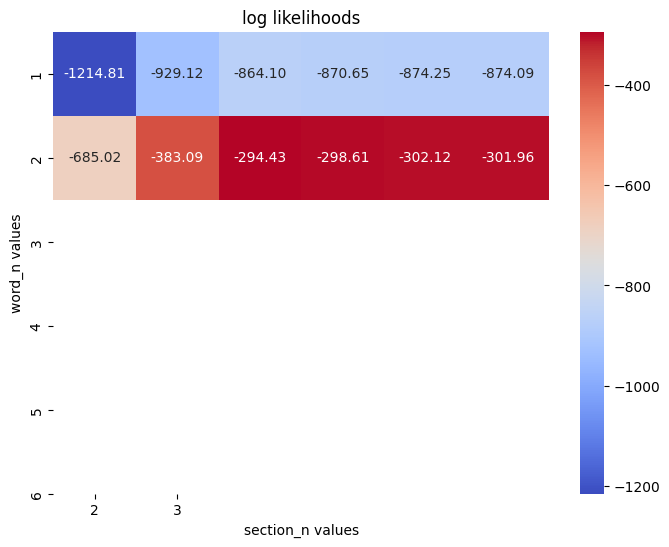

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

section_n = [2, 3]
word_n = [1, 2, 3, 4, 5, 6]

log_likelihoods = np.zeros((len(section_n), len(word_n)))
for i, s_n in enumerate(section_n):
    for j, w_n in enumerate(word_n):
        tmp_hmm = NGramHMM(states, tag="pop", word_n=w_n, section_n=s_n, vocab_size=500)
        tmp_hmm.fit(dataset)
        log_likelihoods[i, j] = tmp_hmm.get_log_likelihood(eval_lyrics)
        print(log_likelihoods[i, j])

# plot log likelihoods for pop songs with vocab size 500
plt.figure(figsize=(8, 6))
sns.heatmap(log_likelihoods, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=section_n, yticklabels=word_n)
plt.xlabel("section_n values")
plt.ylabel("word_n values")
plt.title("log likelihoods")
plt.show()

Text(0.5, 1.0, 'word n-gram vs. Log_Likelihood for section n = 2')

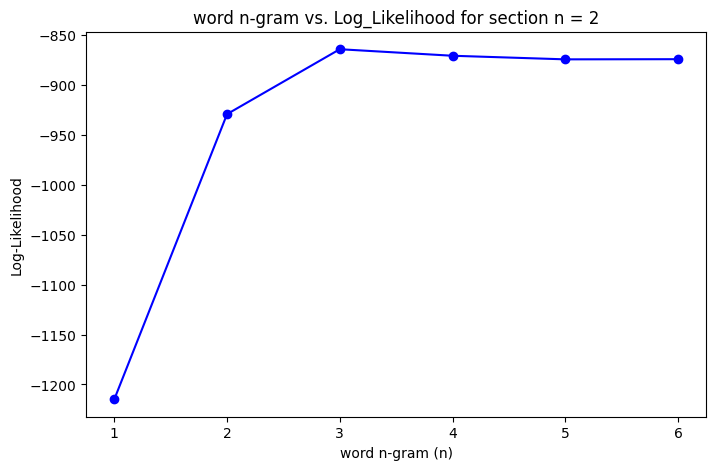

In [68]:
plt.figure(figsize=(8, 5))
plt.plot(word_n, log_likelihoods[0], marker='o', linestyle='-', color='b')
plt.xlabel("word n-gram (n)")
plt.ylabel("Log-Likelihood")
plt.title("word n-gram vs. Log_Likelihood for section n = 2")

Text(0.5, 1.0, 'word n-gram vs. Log_Likelihood for section n = 3')

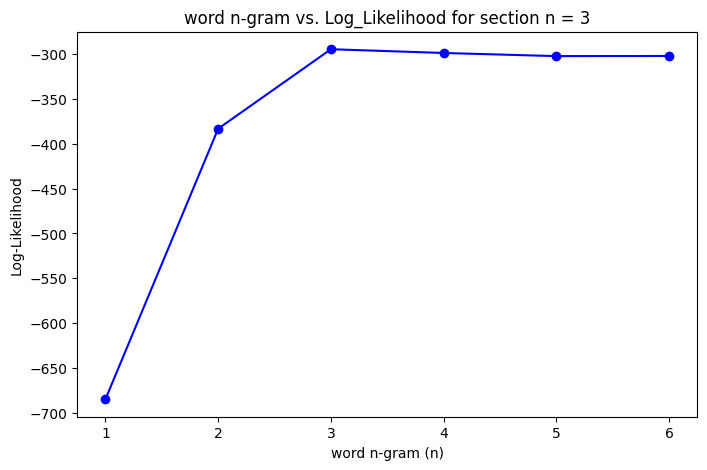

In [69]:
plt.figure(figsize=(8, 5))
plt.plot(word_n, log_likelihoods[1], marker='o', linestyle='-', color='b')
plt.xlabel("word n-gram (n)")
plt.ylabel("Log-Likelihood")
plt.title("word n-gram vs. Log_Likelihood for section n = 3")